<a href="https://colab.research.google.com/github/dsaldana/reinforcement-learning-course/blob/main/lab3_TD_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3: Temporal Difference Learning

In this lab, we will practice TD Learning methods, including SARSA and Q-Learning. Both are tabular methods that work on finite MDP.

We will solve the cliff problem: https://gymnasium.farama.org/environments/toy_text/cliff_walking/#is_slippy


The following code runs in colab, if you want to see the animation, you have to run it using python locally on your computer and replacing render_mode="ansi" for render_mode="human".

Thef follwing code runs the cliff problem using a random policy.

In [42]:
import gymnasium as gym

# Create the environment
env = gym.make("CliffWalking-v1", render_mode="ansi")
#env = gym.make("CliffWalking-v1", render_mode="human")

n_episodes = 5      # number of episodes to run
max_steps = 100     # safety cap

for episode in range(n_episodes):
    state, info = env.reset()
    done = False
    total_reward = 0

    for step in range(max_steps):
        # Random policy: sample an action uniformly
        action = env.action_space.sample()

        next_state, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        state = next_state

        if terminated or truncated:
            break

    print(f"Episode {episode+1}: total reward = {total_reward}")

env.close()

Episode 1: total reward = -1486
Episode 2: total reward = -595
Episode 3: total reward = -2377
Episode 4: total reward = -1387
Episode 5: total reward = -496


## Exercise 1: SARSA
Implement SARSA to solve the cliff problem above. Recommendations:



1. Define your Q table, as a matrix of [number of states] x [number of actions]
2. Greedy policy: Write a function that receives a state, the Q table, and returns the best action (the one with the maximum Q value).
3. $\epsilon$-greedy: Wreite a function that chooses the greedy policy with $\epsilon$ probality, and chooses a random actions with 1-$\epsilon$ probability.
4. Implement the SARSA algorithm based on the pseudo-code



In [44]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

# Reproducibility (optional)
seed = 1
rng = np.random.default_rng(seed)

env = gym.make("CliffWalking-v1", render_mode="ansi")  # None avoids slow text rendering per step
n_states = env.observation_space.n
n_actions = env.action_space.n
Q = np.zeros((n_states, n_actions))

def greedy_action(Q, s):
    """Return argmax_a Q[s,a]."""
    return int(np.argmax(Q[s]))

def epsilon_greedy_action(Q, s, eps, rng):
    """With prob eps pick random action, else greedy."""
    if rng.random() < eps:
        return int(rng.integers(n_actions))
    return greedy_action(Q, s)


# Sarsa Training loop

In [45]:
# Hyperparameters
n_episodes   = 200
max_steps    = 200     # safety cap per episode
alpha        = 0.1     # learning rate
gamma        = 0.99    # discount
eps_start    = 1.0
eps_end      = 0.05
eps_decay    = 0.995   # multiplicative decay per episode

Q = np.zeros((n_states, n_actions), dtype=np.float64)

returns = []
eps = eps_start

for ep in range(n_episodes):
    s, info = env.reset(seed=seed)   # Gymnasium returns (obs, info)
    a = epsilon_greedy_action(Q, s, eps, rng)
    G = 0.0

    for t in range(max_steps):
        s_next, r, terminated, truncated, info = env.step(a)
        done = terminated or truncated

        # Choose next action using current policy (SARSA = on-policy)
        a_next = epsilon_greedy_action(Q, s_next, eps, rng)

        # TD target and update
        td_target = r + (0 if done else gamma * Q[s_next, a_next])
        td_error  = td_target - Q[s, a]
        Q[s, a]  += alpha * td_error

        G += r
        s, a = s_next, a_next
        if done:
            break

    returns.append(G)
    eps = max(eps_end, eps * eps_decay)  # decay ε


In [46]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


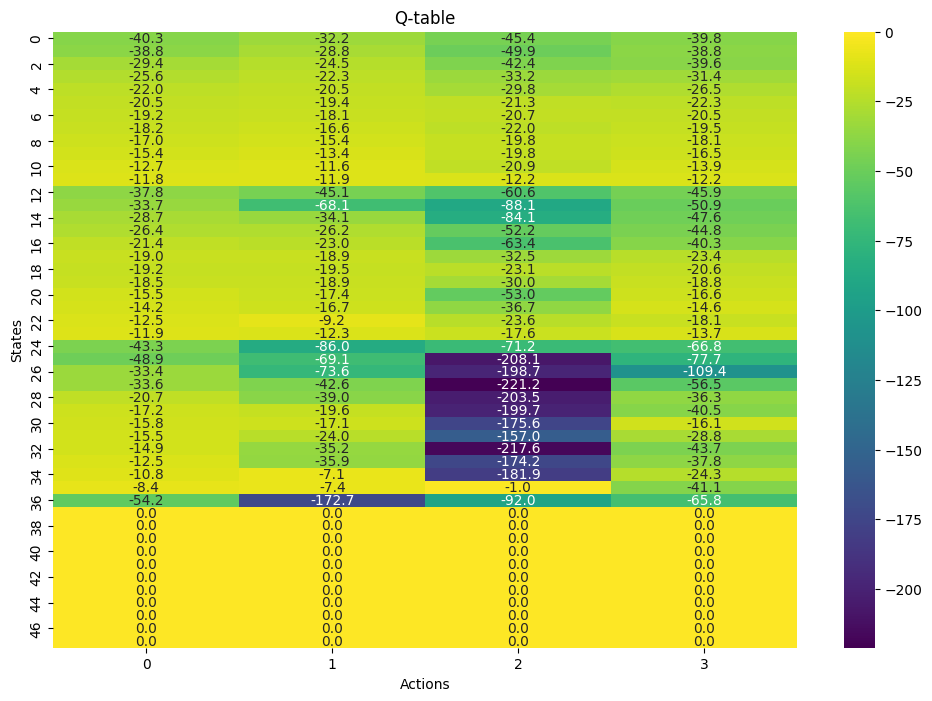

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_Q(Q):
  plt.figure(figsize=(12, 8))
  sns.heatmap(Q, annot=True, fmt=".1f", cmap="viridis")
  plt.xlabel("Actions")
  plt.ylabel("States")
  plt.title("Q-table")
  plt.show()

plot_Q(Q)

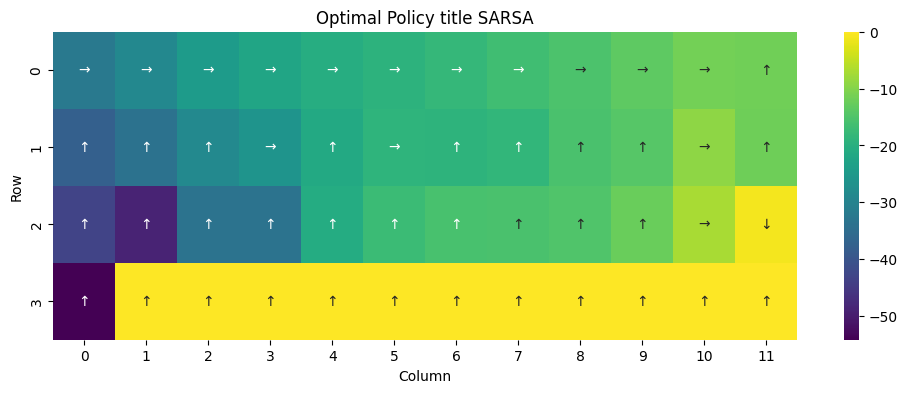

In [48]:
def plot_policy(Q, title="SARSA"):
  # Reshape Q table to a 4x12 grid
  Q_grid = Q.reshape((4, 12, n_actions))

  # Get the optimal action for each state and its corresponding Q-value
  optimal_action = np.argmax(Q_grid, axis=2)
  optimal_policy_Q = np.max(Q_grid, axis=2)

  # Define arrow mapping based on action space (0: up, 1: right, 2: down, 3: left)
  action_arrows = {0: "↑", 1: "→", 2: "↓", 3: "←"}
  optimal_policy_arrows = np.vectorize(action_arrows.get)(optimal_action)

  plt.figure(figsize=(12, 4))
  sns.heatmap(optimal_policy_Q, annot=optimal_policy_arrows, fmt="", cmap="viridis", cbar=True) # Add color bar back
  plt.xlabel("Column")
  plt.ylabel("Row")
  plt.title(f"Optimal Policy title {title}")
  plt.show()
  
plot_policy(Q)

# Learning Curve

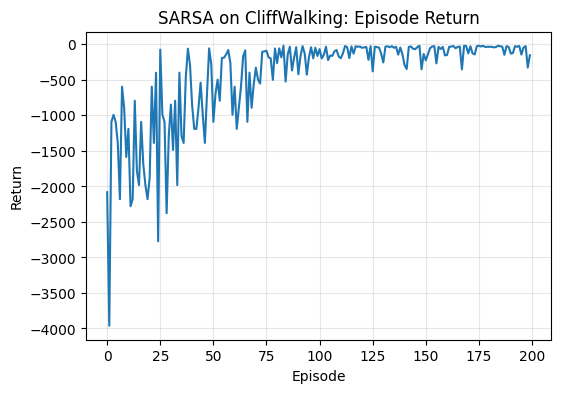

In [49]:
plt.figure(figsize=(6,4))
plt.plot(returns)
plt.xlabel("Episode")
plt.ylabel("Return")
plt.title("SARSA on CliffWalking: Episode Return")
plt.grid(True, alpha=0.3)
plt.show()


## Exercise 2.1: Q: Learning
Implement Q-learning method to solve the cliff problem

In [50]:
# Hyperparameters
n_episodes = 200
max_steps  = 200
alpha      = 0.1
gamma      = 0.99
eps_start  = 1.0
eps_end    = 0.05
eps_decay  = 0.995

Q = np.zeros((n_states, n_actions), dtype=np.float64)
returns = []
eps = eps_start

for ep in range(n_episodes):
    s, info = env.reset(seed=seed)
    G = 0.0

    for t in range(max_steps):
        a = epsilon_greedy_action(Q, s, eps, rng)
        s_next, r, terminated, truncated, info = env.step(a)
        done = terminated or truncated

        # --------- Q-learning TD target (off-policy, greedy next-state value) ----------
        td_target = r + (0 if done else gamma * np.max(Q[s_next]))
        td_error  = td_target - Q[s, a]
        Q[s, a]  += alpha * td_error
        # -------------------------------------------------------------------------------

        G += r
        s = s_next
        if done:
            break

    returns.append(G)
    eps = max(eps_end, eps * eps_decay)


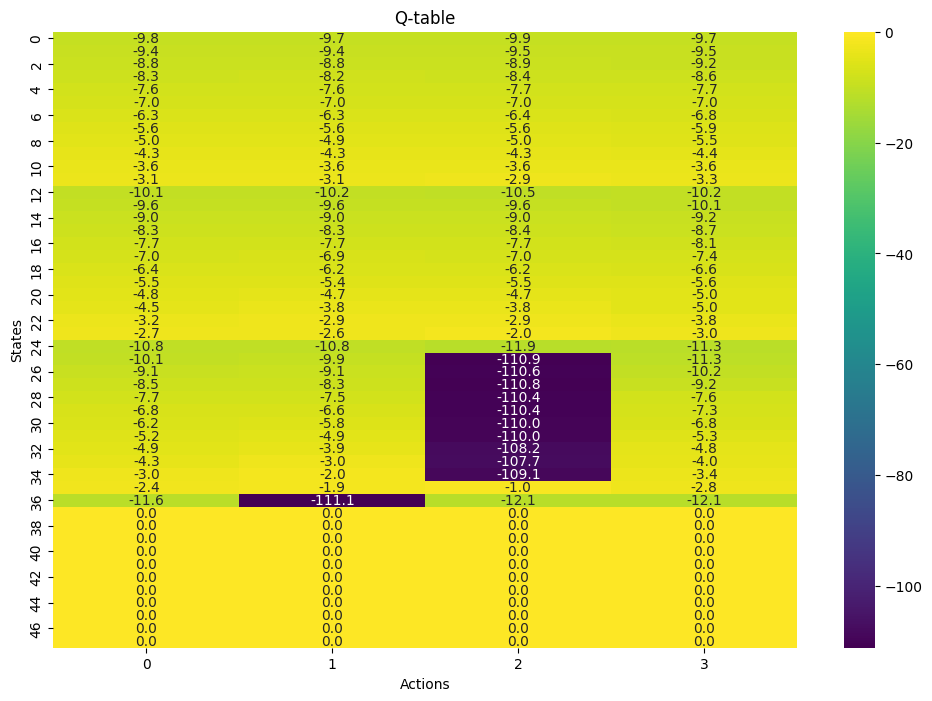

In [51]:
plot_Q(Q)

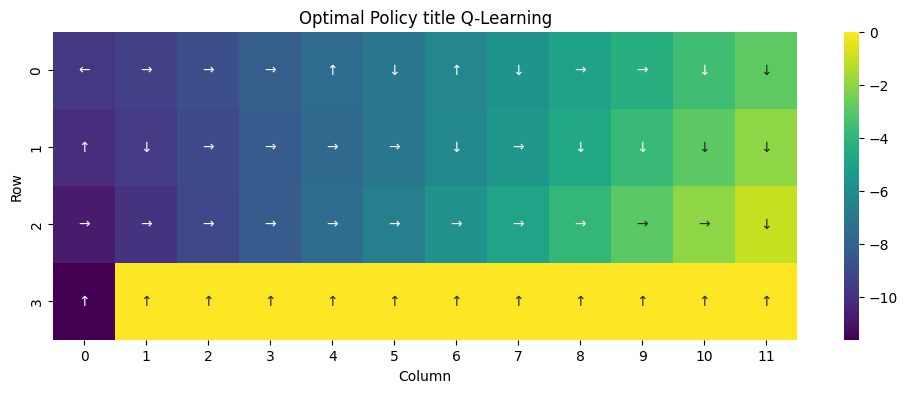

In [52]:
plot_policy(Q, "Q-Learning")

# Learning Curve for Q-Learning 

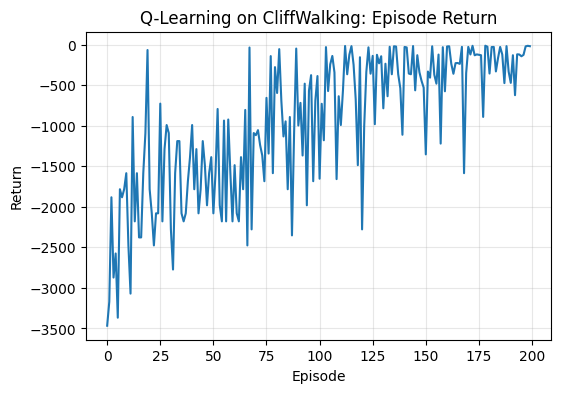

In [53]:
plt.figure(figsize=(6,4))
plt.plot(returns)
plt.xlabel("Episode")
plt.ylabel("Return")
plt.title("Q-Learning on CliffWalking: Episode Return")
plt.grid(True, alpha=0.3)
plt.show()

## Exercise 2.2: SARSA vs Q-learning
 1. Compare the results betwen SARSA and Q-Learning (plot a graph of the sum of rewards duing each episode for each algorithm).
 2. Include the is_slippery=True parameter. Compare again, which one is better?


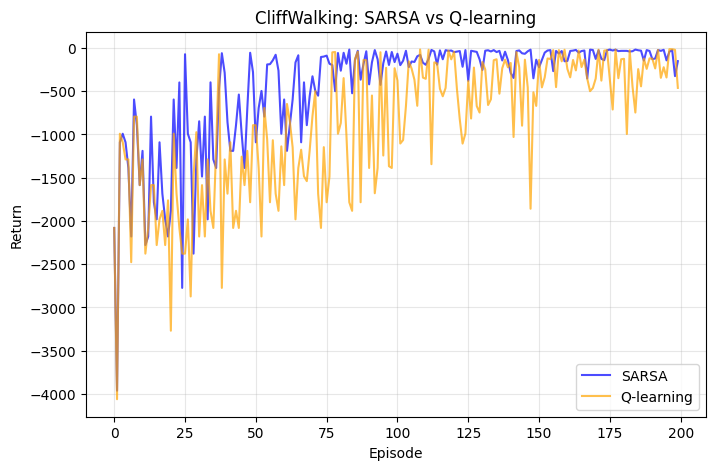

In [54]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

# ----- helper functions -----
def greedy_action(Q, s):
    return int(np.argmax(Q[s]))

def epsilon_greedy_action(Q, s, eps, rng, n_actions):
    if rng.random() < eps:
        return int(rng.integers(n_actions))
    return greedy_action(Q, s)

def train_td(env_name, algo="sarsa",
             n_episodes=200, max_steps=200,
             alpha=0.1, gamma=0.99,
             eps_start=1.0, eps_end=0.05, eps_decay=0.995,
             seed=1):
    """Train SARSA or Q-learning and return (Q, returns)."""
    env = gym.make(env_name, render_mode="ansi")
    n_states  = env.observation_space.n
    n_actions = env.action_space.n
    Q = np.zeros((n_states, n_actions))
    returns = []
    eps = eps_start
    rng = np.random.default_rng(seed)

    for ep in range(n_episodes):
        s, _ = env.reset(seed=seed)
        G = 0.0
        if algo == "sarsa":
            a = epsilon_greedy_action(Q, s, eps, rng, n_actions)

        for _ in range(max_steps):
            if algo == "qlearning":
                a = epsilon_greedy_action(Q, s, eps, rng, n_actions)

            s_next, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated

            if algo == "sarsa":
                a_next = epsilon_greedy_action(Q, s_next, eps, rng, n_actions)
                td_target = r + (0 if done else gamma * Q[s_next, a_next])
            else:  # qlearning
                td_target = r + (0 if done else gamma * np.max(Q[s_next]))

            Q[s, a] += alpha * (td_target - Q[s, a])
            G += r
            s = s_next
            if algo == "sarsa":
                a = a_next
            if done:
                break

        returns.append(G)
        eps = max(eps_end, eps * eps_decay)

    env.close()
    return Q, np.array(returns)

# ----- train both algorithms -----
env_name = "CliffWalking-v1"
Q_sarsa, ret_sarsa = train_td(env_name, algo="sarsa")
Q_q,     ret_q     = train_td(env_name, algo="qlearning")

# ----- plot both learning curves -----
plt.figure(figsize=(8,5))
plt.plot(ret_sarsa, label="SARSA", color="blue", alpha=0.7)
plt.plot(ret_q,     label="Q-learning", color="orange", alpha=0.7)
plt.xlabel("Episode")
plt.ylabel("Return")
plt.title("CliffWalking: SARSA vs Q-learning")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


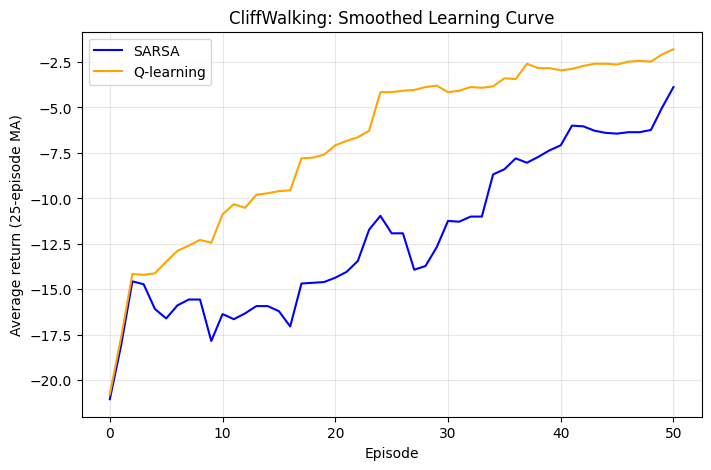

In [61]:
import numpy as np
import matplotlib.pyplot as plt

def moving_average(x, window=50):
    """Simple moving average."""
    return np.convolve(x, np.ones(window)/window, mode='valid')

window = 25   # average over 50 episodes

plt.figure(figsize=(8,5))
plt.plot(moving_average(ret_sarsa, window), label="SARSA", color="blue")
plt.plot(moving_average(ret_q, window), label="Q-learning", color="orange")
plt.xlabel("Episode")
plt.ylabel("Average return ({}-episode MA)".format(window))
plt.title("CliffWalking: Smoothed Learning Curve")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


# Exercise 3 (graduate students): 8x8 grid problem
Solve the 8x8 grid problem from the previous lab. You can use SARSA or Q-learning. How many episodes does it need to learn the optimal policy?


In [27]:
#!pip install gym_simplegrid

%pip install -q gymnasium gym-simplegrid


Note: you may need to restart the kernel to use updated packages.


In [29]:

import gymnasium as gym
import gym_simplegrid

START_LOC = 15
GOAL_LOC = 3
# Define the initial location and the goal location in the grid.
# Each grid cell has an a number from 0 to 63.
options ={
    'start_loc': START_LOC,
    'goal_loc': GOAL_LOC
}

env = gym.make('SimpleGrid-8x8-v0', render_mode='ansi')
obs, info = env.reset(seed=1, options=options)
done = env.unwrapped.done

for t in range(10):
    if done:
        break
    action = env.action_space.sample()   # Random action
    obs, reward, done, _, info = env.step(action)

    grid_size = 8
    row = obs // grid_size
    col = obs % grid_size
    print("Location (", row, ",", col, ") t=",t, " reward=", reward, sep="")

# env.close()

Location (1,6) t=0 reward=0.0
Location (1,7) t=1 reward=0.0
Location (0,7) t=2 reward=0.0
Location (0,6) t=3 reward=0.0
Location (0,6) t=4 reward=-1.0
Location (0,6) t=5 reward=-1.0
Location (0,5) t=6 reward=0.0
Location (1,5) t=7 reward=0.0
Location (2,5) t=8 reward=0.0
Location (2,4) t=9 reward=0.0


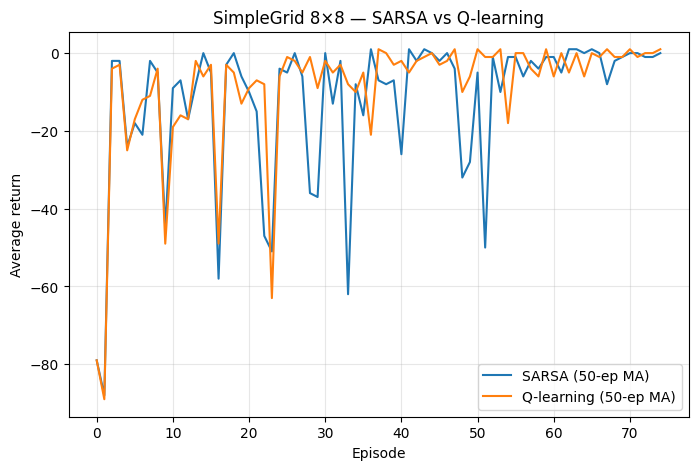

In [58]:
# --- SimpleGrid 8x8: SARSA vs Q-learning (with safe close to avoid SystemExit) ---
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym

# Ensure the env is importable
import gym_simplegrid  # pip install gym-simplegrid

ENV_ID = "SimpleGrid-8x8-v0"
START_LOC, GOAL_LOC = 15, 3
options = {"start_loc": START_LOC, "goal_loc": GOAL_LOC}

def safe_close(env):
    """Close env without letting a sys.exit() kill the notebook."""
    try:
        env.close()
    except SystemExit:
        pass
    except Exception:
        pass

def make_env(render_mode=None):
    try:
        return gym.make(ENV_ID, render_mode=render_mode)
    except SystemExit:
        # Some builds call sys.exit during make/close when using GUI backends
        raise RuntimeError(
            "The environment attempted to exit the process. "
            "Use render_mode=None for training, and avoid closing windows mid-episode."
        )

# Quick probe (and DO NOT hard-close without guard)
env_probe = make_env(render_mode="ansi")
n_states  = env_probe.observation_space.n
n_actions = env_probe.action_space.n
safe_close(env_probe)

# ----- RL helpers -----
def greedy_action(Q, s): return int(np.argmax(Q[s]))
def epsilon_greedy(Q, s, eps, rng, n_actions):
    return int(rng.integers(n_actions)) if rng.random() < eps else greedy_action(Q, s)

def train_td(
    algo="sarsa",
    n_episodes=3000, max_steps=200,
    alpha=0.1, gamma=0.99,
    eps_start=1.0, eps_end=0.05, eps_decay=0.995,
    seed=1,
):
    env = make_env(render_mode="ansi")  # train headless
    n_states  = env.observation_space.n
    n_actions = env.action_space.n
    Q = np.zeros((n_states, n_actions), dtype=np.float64)
    returns = []
    eps = eps_start
    rng = np.random.default_rng(seed)

    for ep in range(n_episodes):
        s, _ = env.reset(seed=seed, options=options)
        G = 0.0

        if algo == "sarsa":
            a = epsilon_greedy(Q, s, eps, rng, n_actions)

        for _ in range(max_steps):
            if algo == "qlearning":
                a = epsilon_greedy(Q, s, eps, rng, n_actions)

            s2, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated

            if algo == "sarsa":
                a2 = epsilon_greedy(Q, s2, eps, rng, n_actions)
                td_target = r + (0 if done else gamma * Q[s2, a2])
            else:  # Q-learning
                td_target = r + (0 if done else gamma * np.max(Q[s2]))

            Q[s, a] += alpha * (td_target - Q[s, a])

            G += r
            s = s2
            if algo == "sarsa":
                a = a2
            if done:
                break

        returns.append(G)
        eps = max(eps_end, eps * eps_decay)

    safe_close(env)
    return Q, np.array(returns)

def moving_average(x, w=50):
    if len(x) < w: return np.array(x, dtype=float)
    return np.convolve(x, np.ones(w)/w, mode="valid")

# ----- Train both agents -----
Q_sarsa, ret_sarsa = train_td(algo="sarsa",    n_episodes=75)
Q_q,     ret_q     = train_td(algo="qlearning", n_episodes=75)

# ----- Plot learning curves (smoothed for readability) -----
plt.figure(figsize=(8,5))
plt.plot(moving_average(ret_sarsa, 1), label="SARSA (50-ep MA)")
plt.plot(moving_average(ret_q, 1),     label="Q-learning (50-ep MA)")
plt.xlabel("Episode"); plt.ylabel("Average return")
plt.title("SimpleGrid 8×8 — SARSA vs Q-learning")
plt.legend(); plt.grid(True, alpha=0.3)
plt.show()


## Answer

Aproximately it needs 60 epsidoes to learn the Optimal Policy